### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

epsilon = np.finfo(np.float32).eps

with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

unique_metrics = ['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 # 'marylandbridge',
 'meehl',
 'motyka',
 'soergel',
 'wave_hedges',
 'kulczynski',
 # 'add_chisq'
                 ]


final_features = [
    "SPM_A_Y",
    "Multiband_period",
    "r-i",
    "Harmonics_phase_4_i",
    "Harmonics_phase_2_r",
    "Power_rate_4",
]

In [2]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

features = features.sample(frac=1)

y_normal_df = features["class"]
# X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)
X_normal_df = features.loc[:, final_features]

other_features_df = pd.read_parquet("data/otherclassobjs_features.parquet")
other_features_df.index.name = "snid"
other_lc_df = pd.read_parquet("data/otherclassobjs.parquet")
other_lc_df.index.name = "snid"

other_lc_df=other_lc_df[~other_lc_df["class"].isin(['d-Sct', 'Cepheid', 'EB', 'RRL'])]
other_features_df=other_features_df.loc[other_lc_df.index]


other_lc_df = other_lc_df.loc[other_features_df.index]

assert (other_lc_df.index == other_features_df.index).all()

X_anom_df = other_features_df.loc[:, X_normal_df.columns].dropna()
X_anom_df = X_anom_df.drop(np.intersect1d(X_anom_df.index, X_normal_df.index))
y_anom_df = other_lc_df.loc[X_anom_df.index]["class"]
X_anom_df=X_anom_df.loc[y_anom_df.index]

X_df = pd.concat([X_normal_df, X_anom_df])
y_df = pd.concat([y_normal_df, y_anom_df])

In [3]:
assert (X_df.index == y_df.index).all()

### 1. Isolation Forest

In [4]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [5]:
def runif(random_state, X_traindf, X_testdf):
    clf = IsolationForest(
        max_samples=10, contamination="auto", random_state=random_state
    )
    clf.fit(X_traindf)  # , sample_weight=1.0/(Xfixed[:,2,:])**2)
    scores_pred_Norm = clf.decision_function(X_testdf)
    # scores_pred_Norm = clf.score_samples(X)
    # .sample_score(X)

    threshold_Norm = stats.scoreatpercentile(scores_pred_Norm, 100 * 0.1)
    #y_predNorm = clf.predict(X)
    abornmality = -scores_pred_Norm
    iforest_df = pd.DataFrame(
        abornmality, columns=["abnormality"], index=X_testdf.index,
    )  # higher is more abnormal
    # iforest_df.index.name = "sample_num"
    # iforest_df = iforest_df.sort_values(by="abnormality", ascending=False)
    return iforest_df.index, iforest_df

In [6]:
ranksIF = []
ranksIDdfs = []
ifseeds = np.random.randint(100, 1000, 3)
for i in ifseeds:
    _ = runif(i, X_traindf=X_normal_df, X_testdf=X_df)
    ranksIF.append(_[0])
    ranksIDdfs.append(_[1])
ranksIF

[Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318),
 Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318),
 Index([ 93852051, 133953454, 156704754,  94869465, 143158599,  97209193,
        118286557, 145870285, 107197896,  34324163,
        ...
         85155628,  35432717,  89686555, 132925610, 135470168,  69018019,
         97601275,  97897233, 130127663,  90121628],
       dtype='int64', name='snid', length=4318)]

In [7]:
df=pd.concat(ranksIDdfs,axis=1)
df.columns = ["if1", "if2", "if3"]
# df = df.sort_values(by="if2",ascending=False)
df

,if1,if2,if3
snid,,,
93852051,-0.068849,-0.071211,-0.046096
133953454,-0.055542,-0.054078,-0.056086
156704754,-0.029540,-0.041390,-0.058449
94869465,-0.024997,-0.017251,-0.030555
143158599,-0.031106,-0.036637,-0.025699
...,...,...,...
69018019,0.038510,0.046227,0.034200
97601275,0.023298,0.026593,0.048065
97897233,0.068889,0.073125,0.063602


In [8]:
assert (df.index==y_df.index).all()

In [9]:
df["class"] = y_df.loc[df.index]

In [10]:
df.sort_values("if2",ascending=False).iloc[:20]

,if1,if2,if3,class
snid,,,,
96837672,0.153602,0.155124,0.154811,CEP
34882116,0.140443,0.153602,0.150165,CEP
94602724,0.151189,0.152706,0.151189,CEP
92717442,0.142569,0.149095,0.140373,CEP
125103424,0.144949,0.147896,0.131143,CEP
83406315,0.128089,0.143122,0.129563,CEP
132356710,0.118630,0.141934,0.109123,CEP
59245585,0.123838,0.140197,0.134723,CEP
108559610,0.117724,0.138254,0.141980,CEP


### Distances

In [11]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X_normal_df, y_normal_df)

DistanceMetricClassifier()

In [12]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X_df, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df["minimum_distance"] = dist_df.min(axis=1)
    dist_df["median_distance"] = dist_df.median(axis=1)

    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/16 [00:00<?, ?it/s]

In [13]:
n_metrics = len(unique_metrics)
clusters = np.unique(y_normal_df)
n_clusters = len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=4318
m: n_metrics=16
k: n_clusters=4


In [14]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i, f"{cluster}_dist"]

In [15]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [16]:
dist_aggregates = np.zeros((len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(4318, 3, 2)

In [17]:
dist_minK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
                           for i,metric in enumerate(unique_metrics)])
dist_medK_by_M = np.array([dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
                           for i,metric in enumerate(unique_metrics)])

In [18]:
assert (ranksIDdfs[0].index == X_df.index).all()

## THIS IS THE REASON WHY I REMOVED SORTING FROM IF FUNCTION

In [19]:
dist_aggregates = pd.DataFrame(np.concatenate(
    [np.percentile(dist_minK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the min of clusters
    np.percentile(dist_medK_by_M, [0,0.25,0.5], axis=0), #metric percentiles on the median of clusters
    ]).T,
                               columns=[k+m for k in ["min", "med"] for m in ["min", "25th", "med"]],
                              index=X_df.index)

dist_aggregates = pd.concat([dist_aggregates,df],axis=1)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
93852051,0.016655,0.017370,0.018085,0.068188,0.070155,0.072123,-0.068849,-0.071211,-0.046096,EB
133953454,0.010289,0.010604,0.010920,0.027755,0.027920,0.028085,-0.055542,-0.054078,-0.056086,DSCT
156704754,0.009076,0.009420,0.009763,0.037566,0.038346,0.039125,-0.029540,-0.041390,-0.058449,DSCT
94869465,0.028378,0.028476,0.028574,0.101931,0.104499,0.107067,-0.024997,-0.017251,-0.030555,DSCT
143158599,0.016810,0.017288,0.017767,0.020444,0.020834,0.021225,-0.031106,-0.036637,-0.025699,EB
...,...,...,...,...,...,...,...,...,...,...
69018019,0.204525,0.207504,0.210484,0.581641,0.583107,0.584574,0.038510,0.046227,0.034200,dwarf-nova
97601275,0.064405,0.066193,0.067981,0.207490,0.215244,0.222997,0.023298,0.026593,0.048065,dwarf-nova
97897233,0.212789,0.217499,0.222210,0.540477,0.541593,0.542708,0.068889,0.073125,0.063602,dwarf-nova


In [20]:
assert (dist_aggregates.index == X_df.index).all()

In [21]:
df = dist_aggregates

In [22]:
assert (df.index == X_df.index).all()

In [23]:
df.sort_values("if2",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
96837672,0.524844,0.530075,0.535306,0.725470,0.734108,0.742747,0.153602,0.155124,0.154811,CEP
34882116,0.502568,0.505085,0.507601,0.719989,0.726740,0.733491,0.140443,0.153602,0.150165,CEP
94602724,0.392684,0.398468,0.404252,0.716352,0.723950,0.731548,0.151189,0.152706,0.151189,CEP
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.142569,0.149095,0.140373,CEP
125103424,0.517682,0.519754,0.521826,0.733617,0.741558,0.749499,0.144949,0.147896,0.131143,CEP
83406315,0.519896,0.521581,0.523266,0.793398,0.798664,0.803930,0.128089,0.143122,0.129563,CEP
132356710,0.298418,0.301491,0.304563,0.703075,0.708009,0.712944,0.118630,0.141934,0.109123,CEP
59245585,0.429654,0.433329,0.437005,0.717416,0.721812,0.726209,0.123838,0.140197,0.134723,CEP
108559610,0.289966,0.295964,0.301962,0.709159,0.712365,0.715571,0.117724,0.138254,0.141980,CEP


In [24]:
df.sort_values("medmed",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
50610308,0.444243,0.448872,0.453501,0.857131,0.858411,0.859691,0.076815,0.075586,0.072786,CEP
91170406,0.632044,0.632508,0.632973,0.829542,0.830873,0.832203,0.103774,0.124416,0.097899,PISN-STELLA_HECORE
152565269,0.311507,0.317303,0.323100,0.828639,0.829623,0.830608,0.075118,0.075170,0.064149,uLens-Binary
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.142569,0.149095,0.140373,CEP
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.146843,0.119747,0.129081,SNIa-91bg
83406315,0.519896,0.521581,0.523266,0.793398,0.798664,0.803930,0.128089,0.143122,0.129563,CEP
130307557,0.590554,0.592339,0.594124,0.790761,0.796645,0.802529,0.140443,0.133194,0.139015,CEP
140819459,0.700631,0.701320,0.702008,0.791081,0.792293,0.793506,0.103121,0.076347,0.109615,dwarf-nova
1067946,0.310913,0.311546,0.312180,0.769761,0.772123,0.774486,0.097046,0.063838,0.078952,CEP


In [25]:
df.sort_values("med25th",ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
50610308,0.444243,0.448872,0.453501,0.857131,0.858411,0.859691,0.076815,0.075586,0.072786,CEP
91170406,0.632044,0.632508,0.632973,0.829542,0.830873,0.832203,0.103774,0.124416,0.097899,PISN-STELLA_HECORE
152565269,0.311507,0.317303,0.323100,0.828639,0.829623,0.830608,0.075118,0.075170,0.064149,uLens-Binary
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.146843,0.119747,0.129081,SNIa-91bg
92717442,0.615692,0.618393,0.621094,0.811991,0.817535,0.823079,0.142569,0.149095,0.140373,CEP
...,...,...,...,...,...,...,...,...,...,...
128890507,0.009598,0.009751,0.009903,0.012617,0.012983,0.013349,-0.017540,-0.002020,-0.033250,DSCT
107777829,0.010531,0.010676,0.010822,0.011371,0.011794,0.012218,-0.057040,-0.056953,-0.039475,EB
140260087,0.010477,0.010626,0.010776,0.011280,0.011790,0.012300,-0.033110,-0.034321,-0.053837,DSCT


In [26]:
df.sort_values("minmed",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
88253880,0.772094,0.774938,0.777782,0.817486,0.818667,0.819848,0.146843,0.119747,0.129081,SNIa-91bg
141445943,0.708816,0.708842,0.708867,0.736282,0.738020,0.739758,0.087990,0.097802,0.100344,ILOT
37734415,0.703729,0.706049,0.708370,0.709919,0.713442,0.716965,0.133194,0.110279,0.114309,dwarf-nova
140819459,0.700631,0.701320,0.702008,0.791081,0.792293,0.793506,0.103121,0.076347,0.109615,dwarf-nova
118315745,0.695961,0.696131,0.696301,0.758498,0.759856,0.761215,0.114207,0.111778,0.125909,uLens-Single-GenLens
114522598,0.683073,0.683463,0.683853,0.769395,0.771519,0.773644,0.113644,0.112742,0.134063,uLens-Single-GenLens
103313063,0.679649,0.681714,0.683778,0.682937,0.686510,0.690083,0.098283,0.087167,0.095813,SNIa-91bg
99141506,0.675586,0.676646,0.677705,0.720873,0.722699,0.724525,0.095781,0.088798,0.097964,dwarf-nova
43265685,0.671533,0.671927,0.672321,0.724747,0.725552,0.726356,0.092096,0.083064,0.086904,PISN-STELLA_HYDROGENIC


In [27]:
normal_classes = ["CEP", "DSCT", "EB", "RRL"]
df['status'] = df['class'].apply(lambda x: 'normal' if x in normal_classes else 'anomalous')

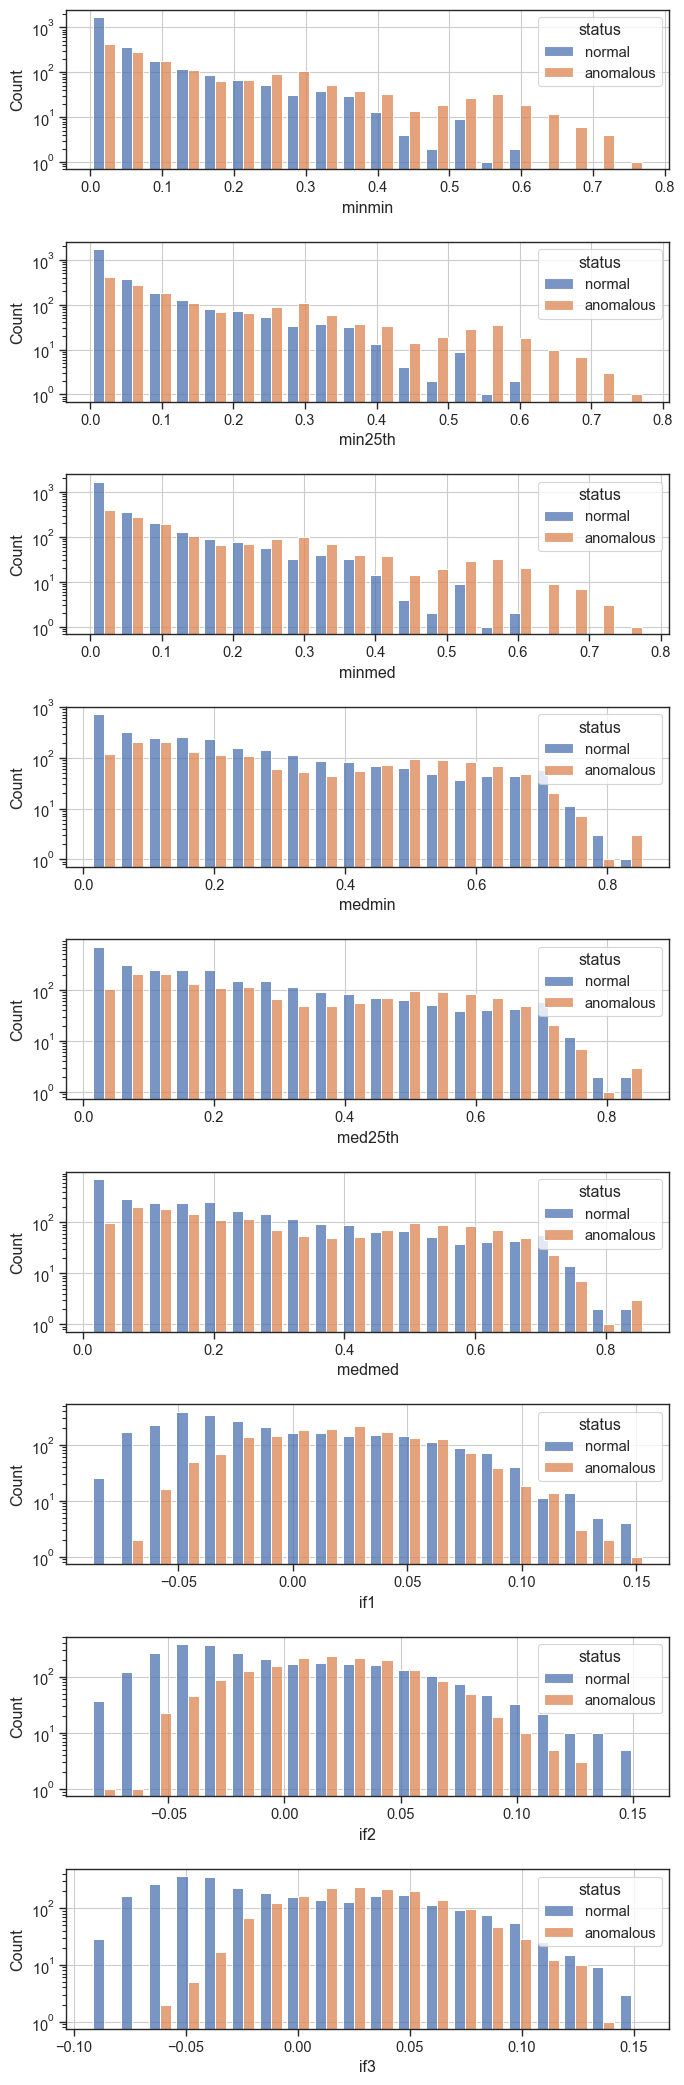

In [28]:
all_methods=["minmin", "min25th", "minmed", "medmin", "med25th", "medmed", "if1", "if2", "if3"]
fig, axs = plt.subplots(len(all_methods),1, figsize=(7,7*len(all_methods)//3))
axs = axs.ravel()
for i, method in enumerate(all_methods):
    sns.histplot(data=df, x=method, hue='status', multiple="dodge", shrink=0.8, ax=axs[i],bins=20)
    axs[i].set_yscale("log")
plt.tight_layout()
plt.show()